Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1130 - loss: 5.4398 - val_accuracy: 0.1094 - val_loss: 3.6085 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1359 - loss: 4.6948 - val_accuracy: 0.1500 - val_loss: 3.4819 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1139 - loss: 4.4876 - val_accuracy: 0.1625 - val_loss: 3.4125 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1354 - loss: 4.2015 - val_accuracy: 0.2094 - val_loss: 3.3715 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1206 - loss: 4.1422 - val_accuracy: 0.2031 - val_loss: 3.3444 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1373 - loss: 3.9107 - val_accuracy: 0.2125 - val_loss: 3.3280 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 

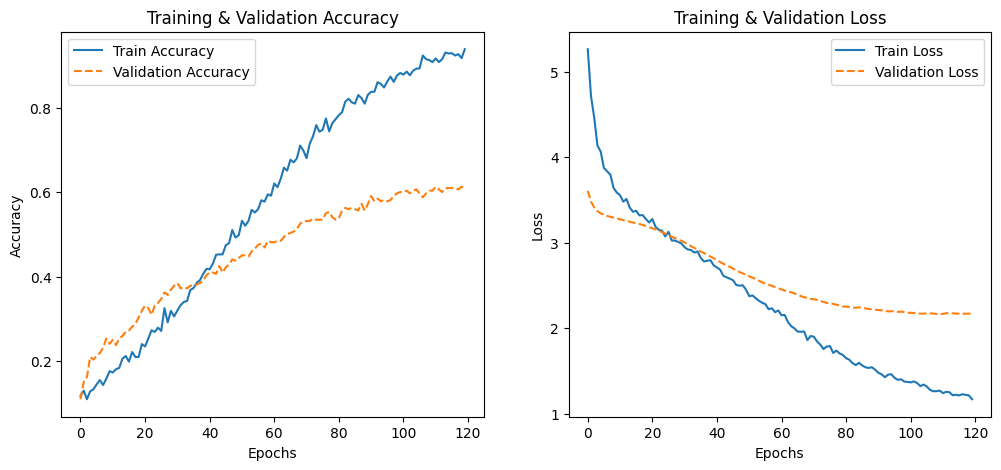

Final Validation Accuracy: 0.6031
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Confusion Matrix:
 [[21  3  0  0  0  0  1  1  4  2]
 [ 1 23  1  0  0  0  0  4  1  2]
 [ 0  0 20 10  0  1  1  0  0  0]
 [ 0  0  0 32  0  0  0  0  0  0]
 [ 1  0  2  1 16  3  1  5  1  2]
 [ 3  1  3  1  0 13  1  2  2  6]
 [ 0  0  0  0  5  1 24  0  2  0]
 [ 4  4  0  0  2  3  2 15  2  0]
 [ 7  1  0  0  1  3  0  0 18  2]
 [ 7  0  0  0  1  1  3  2  7 11]]

Classification Report:
               precision    recall  f1-score   support

           0     0.4773    0.6562    0.5526        32
           1     0.7188    0.7188    0.7188        32
           2     0.7692    0.6250    0.6897        32
           3     0.7273    1.0000    0.8421        32
           4     0.6400    0.5000    0.5614        32
           5     0.5200    0.4062    0.4561        32
           6     0.7273    0.7500    0.7385        32
           7     0.5172    0.4688    0.4918        32
           8     0.4865    0.5625    0.5217        32
         

Model saved at: saved_model\inverted_alexnet_pca.h5


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "inverted_alexnet_pca"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1084 - loss: 3.5899 - val_accuracy: 0.1063 - val_loss: 3.0229 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0857 - loss: 3.4348 - val_accuracy: 0.0938 - val_loss: 3.0077 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1096 - loss: 3.3161 - val_accuracy: 0.0938 - val_loss: 2.9980 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1042 - loss: 3.2637 - val_accuracy: 0.0906 - val_loss: 2.9944 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0972 - loss: 3.2318 - val_accuracy: 0.0812 - val_loss: 2.9905 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1158 - loss: 3.1815 - val_accuracy: 0.0719 - val_loss: 2.9876 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1206

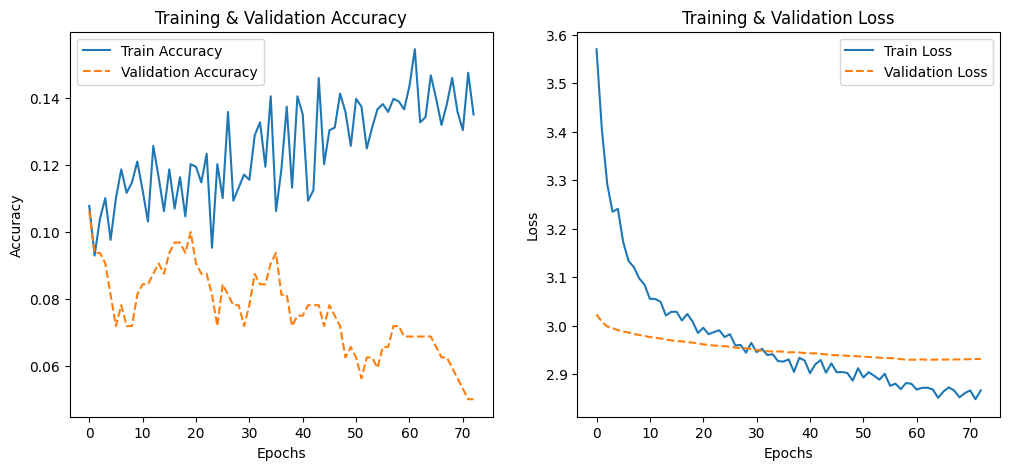

Final Validation Accuracy: 0.0688
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Confusion Matrix:
 [[2 6 2 2 5 0 4 1 8 2]
 [0 1 7 4 4 3 1 2 9 1]
 [0 4 4 1 4 0 7 4 5 3]
 [0 3 3 1 4 4 7 1 9 0]
 [2 3 7 4 0 2 6 3 4 1]
 [0 2 5 1 3 0 6 4 9 2]
 [1 1 4 5 6 1 5 3 5 1]
 [2 2 6 2 6 1 6 4 3 0]
 [1 4 4 2 3 3 8 1 3 3]
 [1 0 6 2 8 0 7 2 4 2]]

Classification Report:
               precision    recall  f1-score   support

           0     0.2222    0.0625    0.0976        32
           1     0.0385    0.0312    0.0345        32
           2     0.0833    0.1250    0.1000        32
           3     0.0417    0.0312    0.0357        32
           4     0.0000    0.0000    0.0000        32
           5     0.0000    0.0000    0.0000        32
           6     0.0877    0.1562    0.1124        32
           7     0.1600    0.1250    0.1404        32
           8     0.0508    0.0938    0.0659        32
           9     0.1333    0.0625    0.0851        32

    accuracy                         0.0688       320


Model weights saved as: saved_model\inverted_alexnet_lda_dbns.weights.h5
Model saved at: saved_model\inverted_alexnet_lda.h5


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "inverted_alexnet_lda"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1093 - loss: 10.2285 - val_accuracy: 0.1031 - val_loss: 4.2389 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1194 - loss: 8.1922 - val_accuracy: 0.1469 - val_loss: 3.7743 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1282 - loss: 7.3789 - val_accuracy: 0.1875 - val_loss: 3.5155 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1105 - loss: 6.8447 - val_accuracy: 0.2156 - val_loss: 3.3462 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1514 - loss: 5.8063 - val_accuracy: 0.2750 - val_loss: 3.2262 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1772 - loss: 5.6320 - val_accuracy: 0.2906 - val_loss: 3.1544 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy:

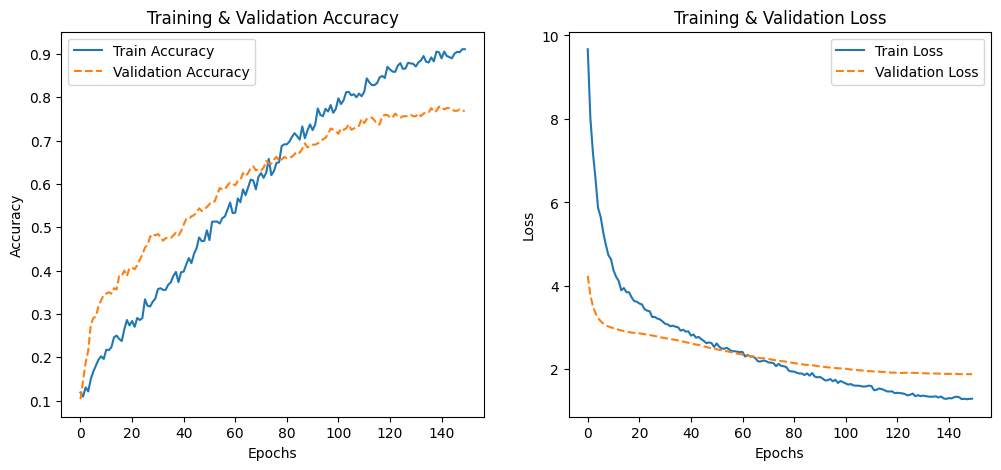

Final Validation Accuracy: 0.7688
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Confusion Matrix:
 [[27  1  0  0  0  1  0  0  1  2]
 [ 2 22  2  0  1  0  0  1  1  3]
 [ 0  0 22  0  4  1  3  2  0  0]
 [ 0  0  0 29  2  0  1  0  0  0]
 [ 0  0  1  1 27  2  0  1  0  0]
 [ 0  3  1  0  4 21  1  0  1  1]
 [ 0  0  0  1  0  0 31  0  0  0]
 [ 2  1  1  0  5  4  0 15  0  4]
 [ 4  0  0  0  0  0  0  0 27  1]
 [ 2  2  0  0  0  1  1  1  0 25]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7297    0.8438    0.7826        32
           1     0.7586    0.6875    0.7213        32
           2     0.8148    0.6875    0.7458        32
           3     0.9355    0.9062    0.9206        32
           4     0.6279    0.8438    0.7200        32
           5     0.7000    0.6562    0.6774        32
           6     0.8378    0.9688    0.8986        32
           7     0.7500    0.4688    0.5769        32
           8     0.9000    0.8438    0.8710        32
         

Model weights saved as: saved_model\inverted_googlenet_pca_dbns.weights.h5
Model saved at: saved_model\inverted_googlenet_pca.h5


In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "inverted_googlenet_pca"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.0997 - loss: 3.5465 - val_accuracy: 0.1031 - val_loss: 2.9965 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0912 - loss: 3.3482 - val_accuracy: 0.0844 - val_loss: 2.9846 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0942 - loss: 3.2661 - val_accuracy: 0.0906 - val_loss: 2.9811 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1144 - loss: 3.2291 - val_accuracy: 0.0875 - val_loss: 2.9784 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1073 - loss: 3.1660 - val_accuracy: 0.0812 - val_loss: 2.9780 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0971 - loss: 3.1383 - val_accuracy: 0.0812 - val_loss: 2.9769 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1

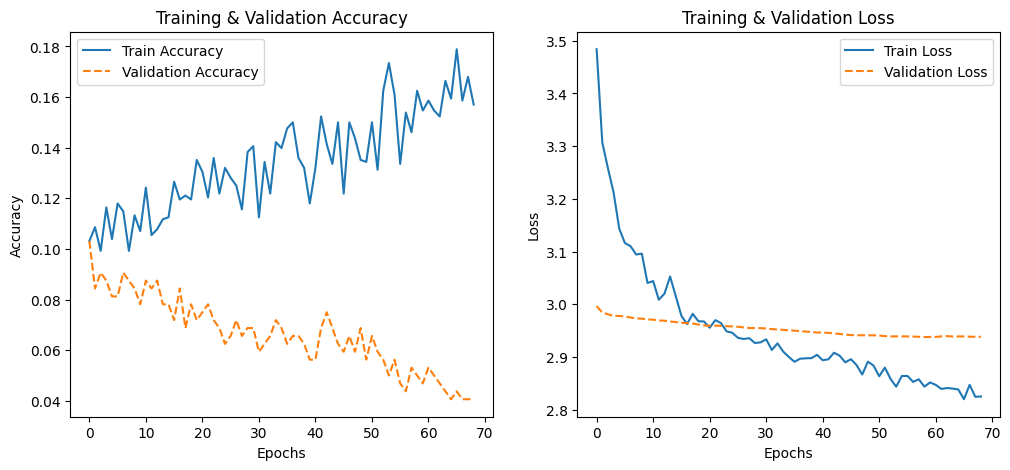

Final Validation Accuracy: 0.0500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Confusion Matrix:
 [[0 6 1 1 4 4 3 5 4 4]
 [3 2 3 3 3 3 3 4 5 3]
 [4 3 0 0 8 3 5 4 2 3]
 [4 5 1 1 4 5 2 3 3 4]
 [4 4 2 3 3 2 3 6 2 3]
 [7 3 2 2 3 3 2 5 1 4]
 [5 4 2 0 1 3 3 4 4 6]
 [2 7 3 0 5 4 1 2 3 5]
 [7 5 1 2 7 3 1 4 1 1]
 [3 3 4 1 6 2 3 3 6 1]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        32
           1     0.0476    0.0625    0.0541        32
           2     0.0000    0.0000    0.0000        32
           3     0.0769    0.0312    0.0444        32
           4     0.0682    0.0938    0.0789        32
           5     0.0938    0.0938    0.0938        32
           6     0.1154    0.0938    0.1034        32
           7     0.0500    0.0625    0.0556        32
           8     0.0323    0.0312    0.0317        32
           9     0.0294    0.0312    0.0303        32

    accuracy                         0.0500       320


Model weights saved as: saved_model\inverted_googlenet_lda_dbns.weights.h5
Model saved at: saved_model\inverted_googlenet_lda.h5


In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "inverted_googlenet_lda"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.1079 - loss: 4.8406 - val_accuracy: 0.1281 - val_loss: 3.5473 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1024 - loss: 4.1081 - val_accuracy: 0.1570 - val_loss: 3.4802 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1262 - loss: 3.7833 - val_accuracy: 0.1883 - val_loss: 3.4483 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1438 - loss: 3.6482 - val_accuracy: 0.1984 - val_loss: 3.4231 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1600 - loss: 3.5862 - val_accuracy: 0.2102 - val_loss: 3.4033 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1617 - loss: 3.5077 - val_accuracy: 0.2219 - val_loss: 3.3813 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 

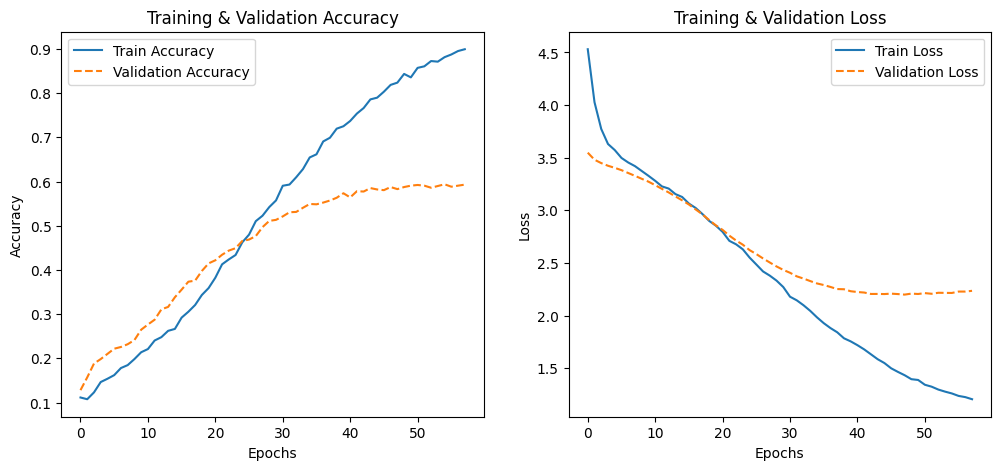

Final Validation Accuracy: 0.5828
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



Confusion Matrix:
 [[80 11  0  0  0  4  0  7 13 13]
 [12 43 21  8  6  7  3 13  5 10]
 [ 0  2 96 11  5  1  7  3  3  0]
 [ 0  1 16 97  2  4  1  7  0  0]
 [ 1  4 12  5 73  7  5 12  6  3]
 [ 6  5  3  3  5 56 17  8 10 15]
 [ 0  1  1 10 12 12 90  1  0  1]
 [15  7  7  5 12  8  3 60  5  6]
 [15  5  1  0  3  4  1  2 82 15]
 [30  6  0  0  1  7  4  2  9 69]]

Classification Report:
               precision    recall  f1-score   support

           0     0.5031    0.6250    0.5575       128
           1     0.5059    0.3359    0.4038       128
           2     0.6115    0.7500    0.6737       128
           3     0.6978    0.7578    0.7266       128
           4     0.6134    0.5703    0.5911       128
           5     0.5091    0.4375    0.4706       128
           6     0.6870    0.7031    0.6950       128
           7     0.5217    0.4688    0.4938       128
           8     0.6165    0.6406    0.6284       128
           9     0.5227    0.5391    0.5308       128

    accuracy                

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "multi_augmented_alexnet_pca"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1015 - loss: 3.2329 - val_accuracy: 0.1086 - val_loss: 2.9600 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1010 - loss: 3.0824 - val_accuracy: 0.1047 - val_loss: 2.9507 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1018 - loss: 3.0453 - val_accuracy: 0.1055 - val_loss: 2.9427 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1101 - loss: 3.0009 - val_accuracy: 0.1039 - val_loss: 2.9380 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1116 - loss: 2.9793 - val_accuracy: 0.1078 - val_loss: 2.9321 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1065 - loss: 2.9497 - val_accuracy: 0.1016 - val_loss: 2.9260 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1098 

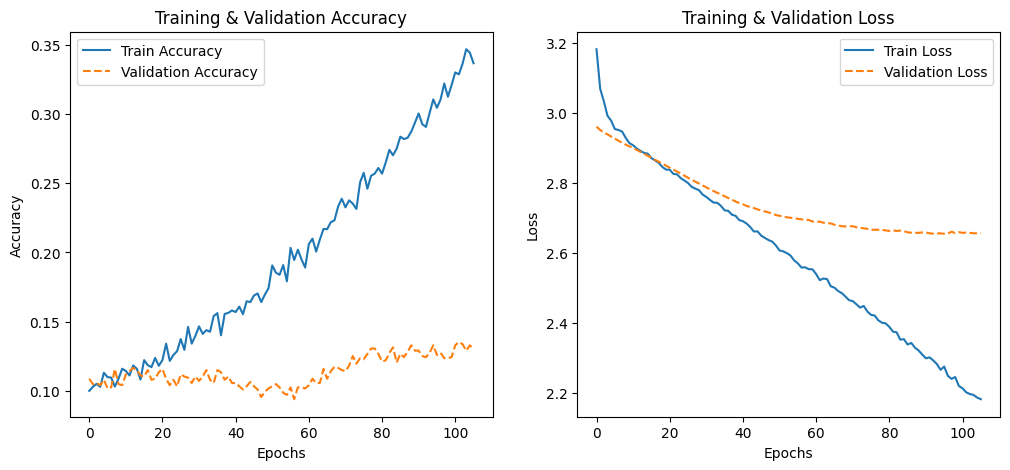

Final Validation Accuracy: 0.1258
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Confusion Matrix:
 [[12 14  8 11 18 17 11  8 11 18]
 [18 21  7  5 27 14  7  5 12 12]
 [18 12 16 10 17 22 10  9  5  9]
 [16 12 12 25 11 14 14  8  7  9]
 [14 18  9 19 12 13 10  9  5 19]
 [19 12  8  9 15 14 13  7 19 12]
 [ 8 12 18 16 15 12 18 10 11  8]
 [16  8 16  5 17 15  8 21 11 11]
 [20 12  9  7 18 16  9 14 12 11]
 [14 12  7 12 14 21 11 16 11 10]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0774    0.0938    0.0848       128
           1     0.1579    0.1641    0.1609       128
           2     0.1455    0.1250    0.1345       128
           3     0.2101    0.1953    0.2024       128
           4     0.0732    0.0938    0.0822       128
           5     0.0886    0.1094    0.0979       128
           6     0.1622    0.1406    0.1506       128
           7     0.1963    0.1641    0.1787       128
           8     0.1154    0.0938    0.1034       128
          

Model weights saved as: saved_model\multi_augmented_alexnet_lda_dbns.weights.h5
Model saved at: saved_model\multi_augmented_alexnet_lda.h5


In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "multi_augmented_alexnet_lda"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.1125 - loss: 7.8225 - val_accuracy: 0.2438 - val_loss: 3.4070 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1709 - loss: 5.0973 - val_accuracy: 0.3383 - val_loss: 3.1678 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2100 - loss: 4.2724 - val_accuracy: 0.3805 - val_loss: 3.0766 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2426 - loss: 3.8676 - val_accuracy: 0.4102 - val_loss: 3.0253 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2617 - loss: 3.6344 - val_accuracy: 0.4320 - val_loss: 2.9773 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2765 - loss: 3.5032 - val_accuracy: 0.4547 - val_loss: 2.9236 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 

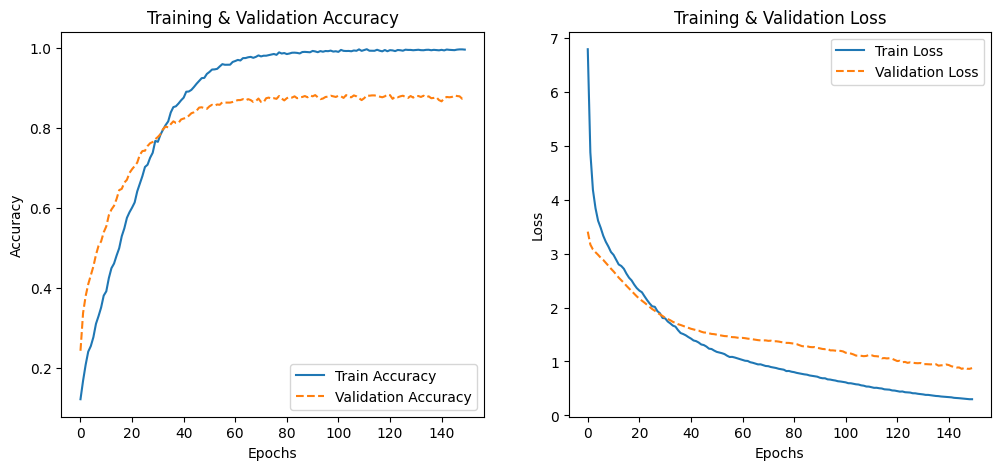

Final Validation Accuracy: 0.8820
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step



Confusion Matrix:
 [[110   4   0   0   0   2   0   3   5   4]
 [  2 101   4   3   3   1   0   8   5   1]
 [  0   5 115   4   1   0   0   3   0   0]
 [  0   3   2 117   1   0   1   4   0   0]
 [  0   1   3   0 113   2   3   4   0   2]
 [  0   4   0   0   8 106   0   9   1   0]
 [  0   0   1   2   0   0 123   0   0   2]
 [  2   8   2   1   9   2   0 103   0   1]
 [  4   2   0   0   0   0   0   0 121   1]
 [  5   0   0   0   0   1   1   0   1 120]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8943    0.8594    0.8765       128
           1     0.7891    0.7891    0.7891       128
           2     0.9055    0.8984    0.9020       128
           3     0.9213    0.9141    0.9176       128
           4     0.8370    0.8828    0.8593       128
           5     0.9298    0.8281    0.8760       128
           6     0.9609    0.9609    0.9609       128
           7     0.7687    0.8047    0.7863       128
           8     0.9098    0.9453    

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "multi_augmented_googlenet_pca"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0932 - loss: 3.4382 - val_accuracy: 0.1109 - val_loss: 2.9645 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1019 - loss: 3.1552 - val_accuracy: 0.1141 - val_loss: 2.9507 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0958 - loss: 3.1080 - val_accuracy: 0.1102 - val_loss: 2.9437 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1020 - loss: 3.0506 - val_accuracy: 0.1086 - val_loss: 2.9397 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1031 - loss: 3.0175 - val_accuracy: 0.1031 - val_loss: 2.9355 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1057 - loss: 2.9929 - val_accuracy: 0.1078 - val_loss: 2.9316 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1060 

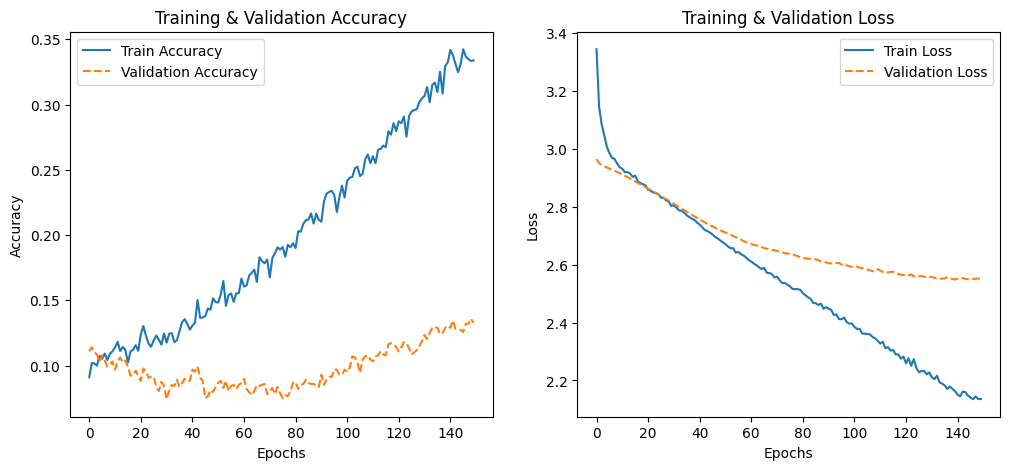

Final Validation Accuracy: 0.1305
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Confusion Matrix:
 [[ 8 16 11 10 15 15 11 17  8 17]
 [10 18 11 14  9 21 13 15  9  8]
 [10 17 22 14  5 14 16 20  5  5]
 [ 8 19 10 28 12 10 14 11  8  8]
 [ 6 18 10 18  8  7 19 16  9 17]
 [12 22  9 11 12  8 16 19 10  9]
 [ 9 13  7 16 10  4 33 22  9  5]
 [12 13 13 15 13  7 12 23 11  9]
 [ 7 18 13 14 15 11 10 24  6 10]
 [ 7 23  8 13 12  6 14 19 13 13]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0899    0.0625    0.0737       128
           1     0.1017    0.1406    0.1180       128
           2     0.1930    0.1719    0.1818       128
           3     0.1830    0.2188    0.1993       128
           4     0.0721    0.0625    0.0669       128
           5     0.0777    0.0625    0.0693       128
           6     0.2089    0.2578    0.2308       128
           7     0.1237    0.1797    0.1465       128
           8     0.0682    0.0469    0.0556       128
         

Model weights saved as: saved_model\multi_augmented_googlenet_lda_dbns.weights.h5
Model saved at: saved_model\multi_augmented_googlenet_lda.h5


In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# DBN-like architecture (Feedforward Neural Network)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Define path to save model
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define model name
model_name = "multi_augmented_googlenet_lda"  # Change this to the new model name

# Save model weights with the correct filename format
model_weights_path = os.path.join(model_dir, f"{model_name}_dbns.weights.h5")  # Corrected extension
model.save_weights(model_weights_path)
print(f"Model weights saved as: {model_weights_path}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")

